In [4]:
from retinaface import RetinaFace
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib.pyplot as plt
from retinaface import RetinaFace
from concurrent.futures import ThreadPoolExecutor
import os
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from retinaface import RetinaFace
import pandas as pd
import scipy.cluster.hierarchy as sch
import face_recognition 

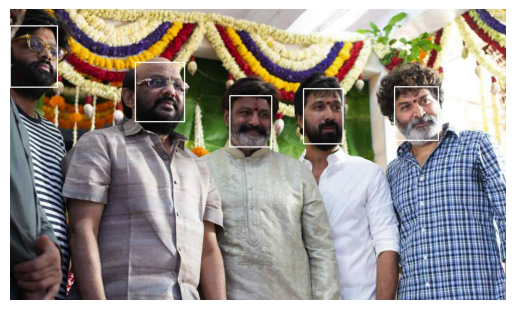

In [10]:
img_path = "./test/NBK109.jpg"
img = cv2.imread(img_path)

faces = RetinaFace.detect_faces(img_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if faces:
    for identity in faces.values():
        facial_area = identity["facial_area"]
        cv2.rectangle(img_rgb, (facial_area[0], facial_area[1]), (facial_area[2], facial_area[3]), (255, 255, 255), 2)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()


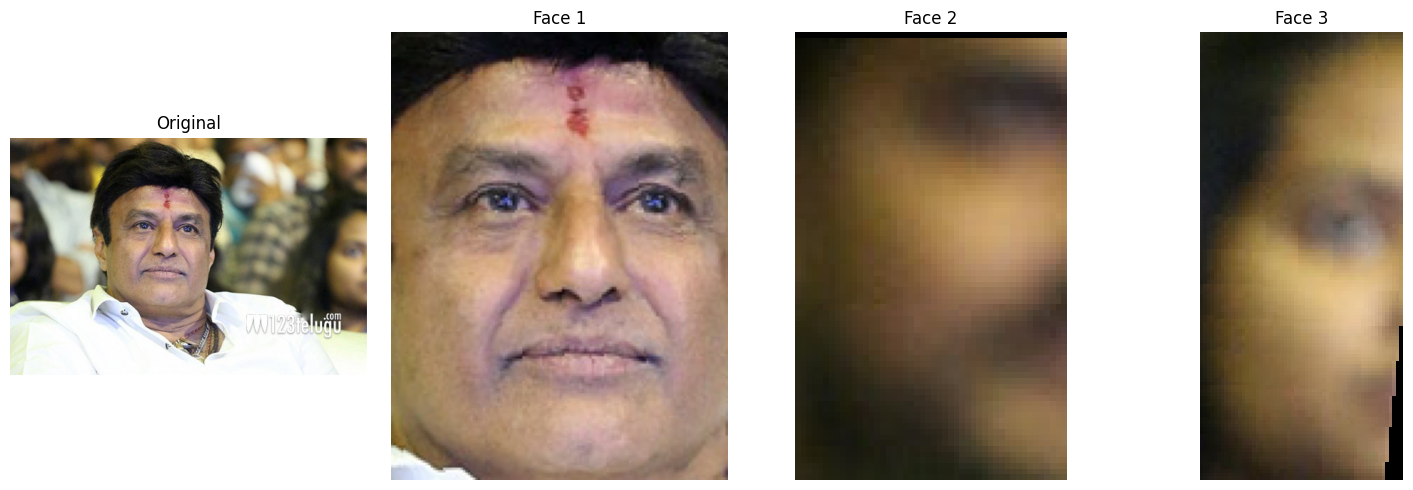

In [18]:
img_path = "./test/Balakrishna.jpg"
faces = RetinaFace.extract_faces(img_path=img_path, align=True)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, len(faces) + 1, figsize=(15, 5))  # Adjust size as needed
axes = axes.flatten()

# Display original image
axes[0].imshow(img_rgb)
axes[0].set_title("Original")
axes[0].axis('off')

if not faces:
    axes[1].text(0.5, 0.5, "No faces detected", horizontalalignment='center', verticalalignment='center', fontsize=12)
    axes[1].axis('off')
else:
    for i, face in enumerate(faces):
        if face.size == 0:
            axes[i + 1].text(0.5, 0.5, "Empty face detected", horizontalalignment='center', verticalalignment='center', fontsize=12)
        else:
            axes[i + 1].imshow(face)
            axes[i + 1].set_title(f"Face {i + 1}")
        axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

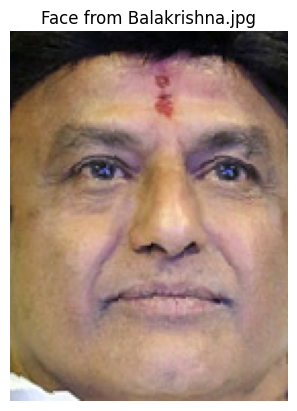

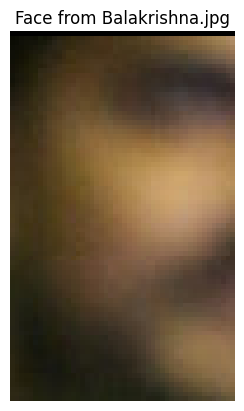

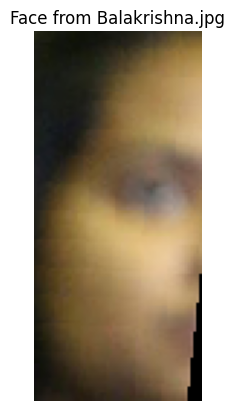

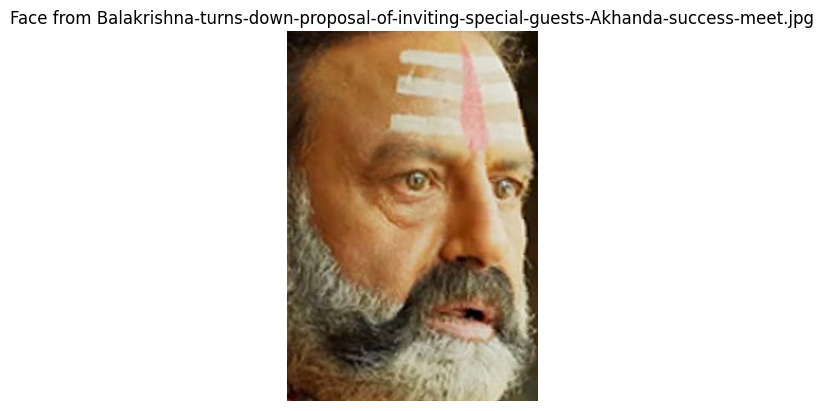

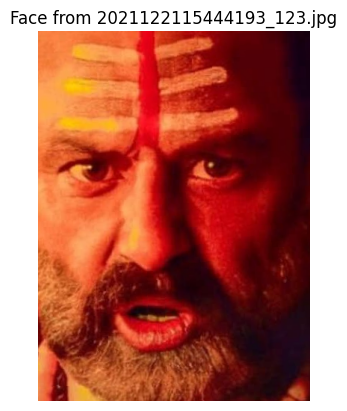

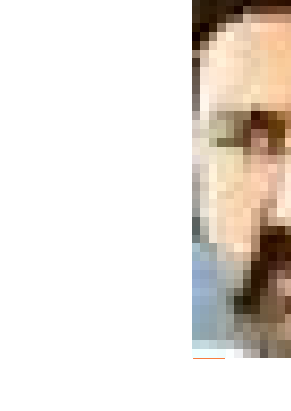

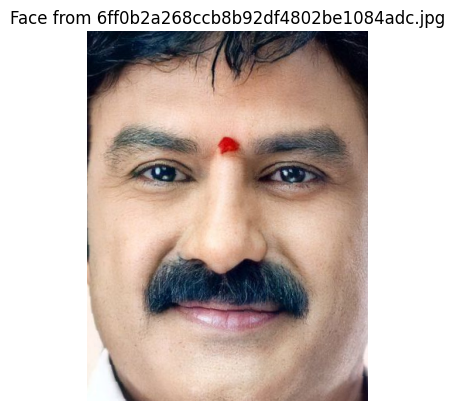

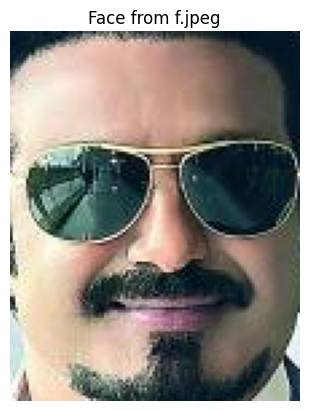

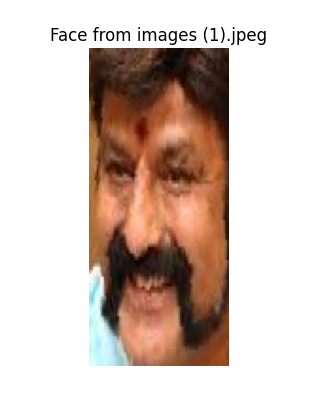

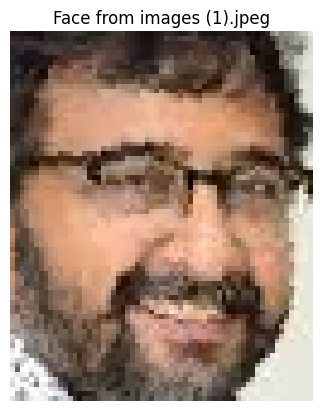

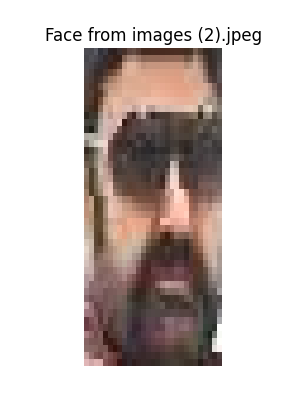

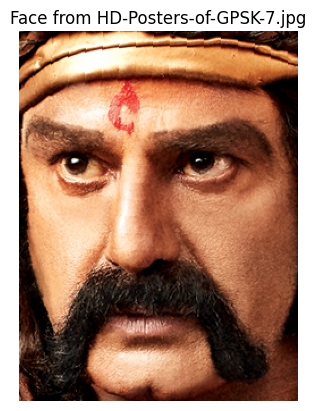

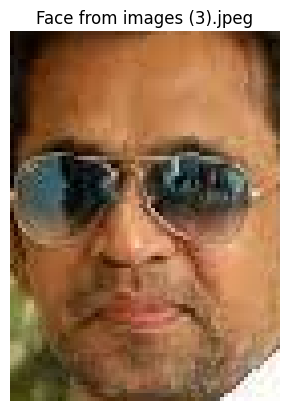

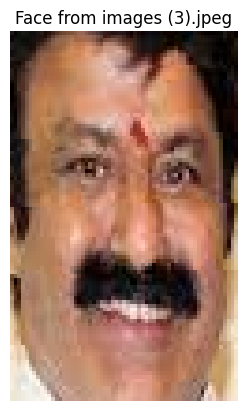

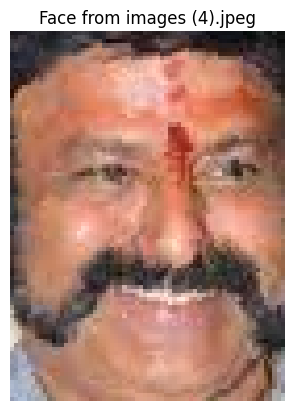

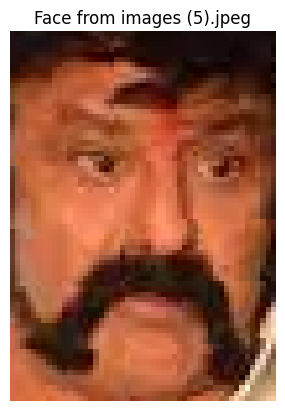

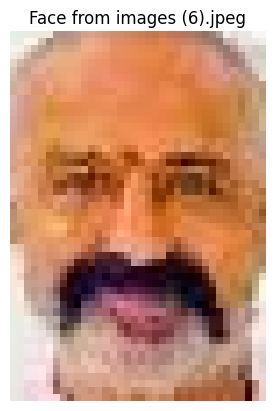

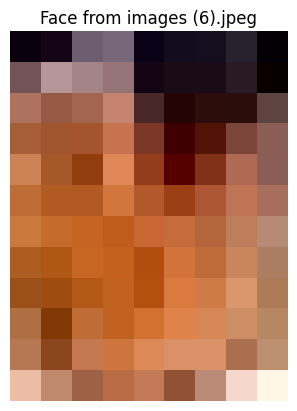

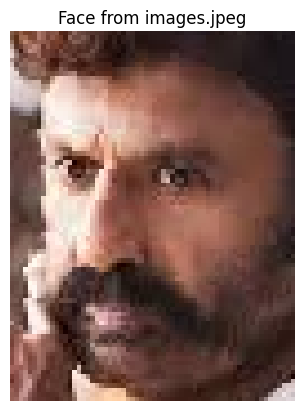

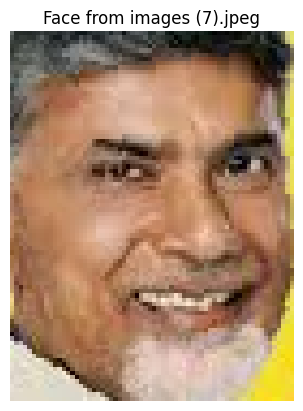

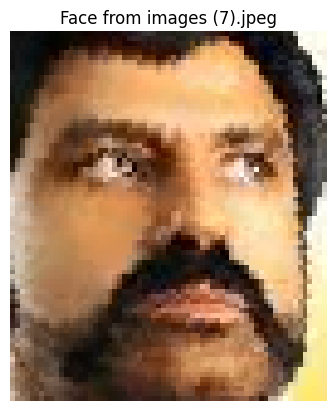

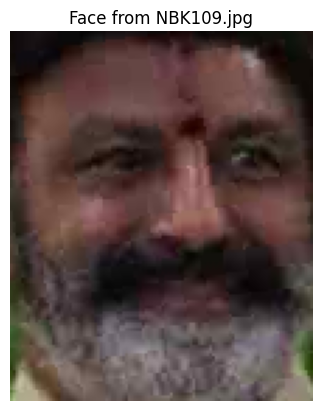

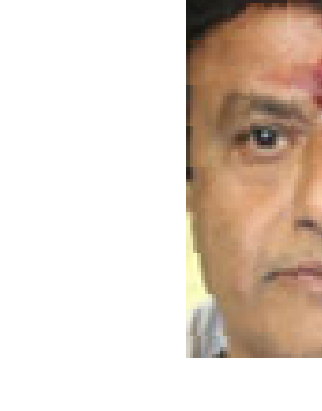

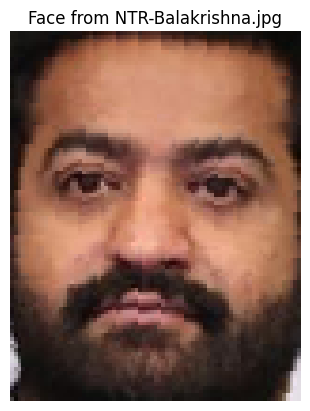

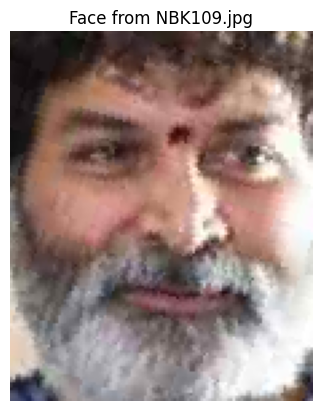

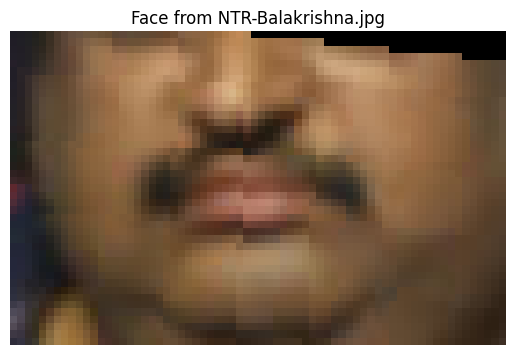

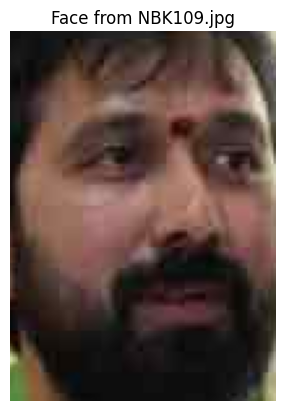

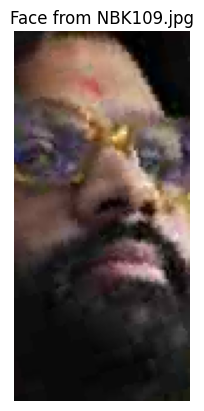

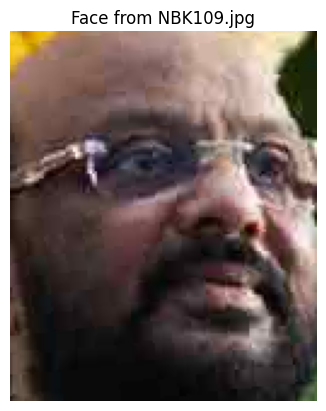

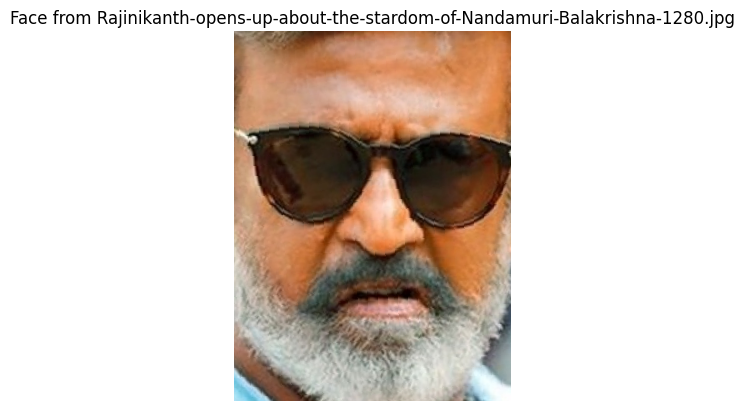

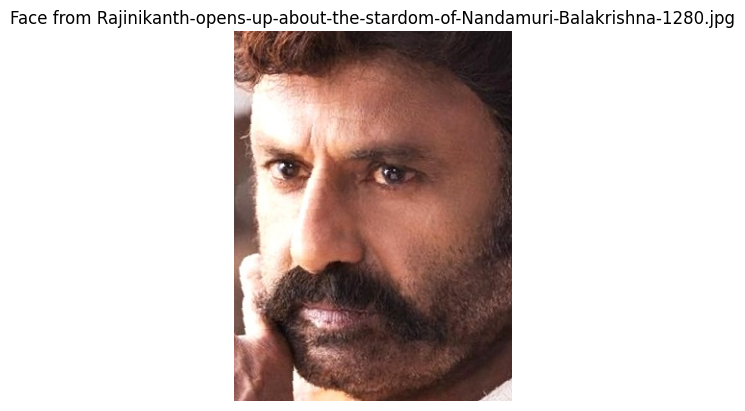

In [1]:
def process_image(image_path):
    faces = RetinaFace.extract_faces(img_path=image_path, align=True)
    
    if not faces:
        print(f"No faces detected in {image_path}.")
    else:
        for face in faces:
            if face.size == 0:
                print(f"Empty face detected in {image_path}.")
            else:
                plt.imshow(face)
                plt.axis('off')
                plt.title(f"Face from {os.path.basename(image_path)}")
                plt.show()

def process_folder(folder_path):
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(process_image, image_files)

if __name__ == "__main__":
    folder_path = "./test"  
    process_folder(folder_path)

In [28]:
# as of now we have implemented the retina-face based face detection now we left with the normalizing the images to array to maintain the proper consistency

In [29]:
# so the challenges we have are the blury images are getting recognized in the test data as it is shown in the above , now we need to implement 
# a cutting edge solution to perform the classification on gpu basis with an api to remove the blurry images which doesnot have any information of faces

In [31]:
# this is the CPU level test stage which identifies the faces in the folder and draw the images and the make and inference to perform labelling them
# as the distint faces in the folders

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from retinaface import RetinaFace
import pandas as pd
import scipy.cluster.hierarchy as sch
from deepface import DeepFace

# Define constants
EMBEDDING_DIM = 128  # This will vary based on the model used

# Initialize a list to store face embeddings and their image paths
face_data = []

def get_face_embedding(face_image):
    """
    Extracts the embedding of a face using DeepFace.
    """
    # Convert face_image to a format suitable for DeepFace
    from PIL import Image
    pil_image = Image.fromarray(face_image)
    np_image = np.array(pil_image)
    np_image = np_image[..., :3]  
    try:
        embeddings = DeepFace.represent(img_path=np_image, model_name='VGG-Face', enforce_detection=False)
        return embeddings[0]['embedding']
    except Exception as e:
        print(f"Error extracting embedding: {e}")
        return np.zeros(EMBEDDING_DIM)

def process_image(image_path):
    """
    Processes a single image to extract faces and store their embeddings.
    """
    faces = RetinaFace.extract_faces(img_path=image_path, align=True)
    
    if not faces:
        print(f"No faces detected in {image_path}.")
    else:
        for face in faces:
            if face.size == 0:
                print(f"Empty face detected in {image_path}.")
            else:
                embedding = get_face_embedding(face)
                face_data.append((embedding, image_path, face))

def process_folder(folder_path):
    """
    Processes all images in a folder to extract face embeddings and cluster them.
    """
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(process_image, image_files)
    
    # Extract embeddings and image paths
    embeddings = np.array([data[0] for data in face_data])
    image_paths = [data[1] for data in face_data]
    faces = [data[2] for data in face_data]
    
    if len(embeddings) == 0:
        print("No faces to cluster.")
        return

    scaler = StandardScaler()
    embeddings = scaler.fit_transform(embeddings)

    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5, linkage='ward')
    labels = clustering.fit_predict(embeddings)

    df = pd.DataFrame({
        'Image Path': image_paths,
        'Cluster': labels,
        'Face': faces
    })
    
    unique_clusters = df['Cluster'].unique()

    for cluster in unique_clusters:
        representative_face = df[df['Cluster'] == cluster].iloc[0]
        plt.imshow(representative_face['Face'])
        plt.axis('off')
        plt.title(f"Cluster {cluster} - Face from {os.path.basename(representative_face['Image Path'])}")
        plt.show()

    # Plot dendrogram
    distance_matrix = cosine_similarity(embeddings)
    linkage_matrix = sch.linkage(distance_matrix, method='ward')
    plt.figure(figsize=(10, 7))
    sch.dendrogram(linkage_matrix, labels=image_paths, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Dendrogram')
    plt.xlabel('Image')
    plt.ylabel('Distance')
    plt.show()

if __name__ == "__main__":
    folder_path = "./test" 
    process_folder(folder_path)
